# Problem 1 - Using a Pre-Trained CNN

## Part 1 - Using Pre-Trained Deep CNN

In [1]:
from __future__ import print_function, division
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import torchvision
import shutil
import os
import pandas
import torch
import numpy as np
import time
import copy
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import normalize as norm
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(0)

'Quadro RTX 5000 with Max-Q Design'

In [4]:
# Using GPU device
gpu_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading

In [5]:
# Load image
peppers_image = cv2.imread("peppers.jpg")
peppers_image = cv2.cvtColor(peppers_image, cv2.COLOR_BGR2RGB)
peppers_image.shape

(384, 512, 3)

In [6]:
pep_ts = torch.from_numpy(peppers_image)

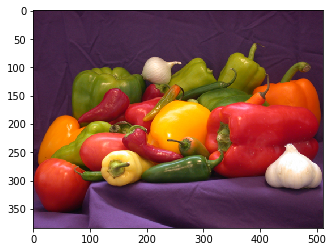

In [7]:
_ = plt.imshow(pep_ts)

### Going to use ResNet-152

In [8]:
# Load the pre trained model
res_152_model = models.resnet152(pretrained = True)
_ = res_152_model.eval()

In [9]:
# Load all the resnet 1000 labels
with open("imagenet_class_index.json") as f:
    resnet_labels = json.load(f)

### Preprocessing

In [10]:
# Create pipeline to preprocess the image, size and turn into pytorch tensor
pre_process = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((224, 224)), transforms.ToTensor()])

In [11]:
# Transform
pep_ts = pre_process(peppers_image)

In [12]:
# Put into batch to run in the model
pep_batch = torch.unsqueeze(pep_ts, 0)

In [13]:
pep_batch.size()

torch.Size([1, 3, 224, 224])

In [14]:
# Predict with model
output_res_152 = res_152_model(pep_batch)

In [15]:
# Print the top 3
_, indexes_res_152 = torch.topk(output_res_152, 3)
p_res_152 = torch.nn.functional.softmax(output_res_152, dim = 1)[0] * 100
final_p_res_152 = []
for index in indexes_res_152[0]:
    final_p_res_152.append([resnet_labels[str(int(index))][1], p_res_152[int(index)].item()])
df_res_152 = pd.DataFrame(final_p_res_152, columns = ['predicted categories', '% probabilities'])
df_res_152

,predicted categories,% probabilities
0,bell_pepper,80.637512
1,nipple,5.370522
2,corn,2.232531


The pre-trained resnet 152 has recognized the bell pepper in the image.

## Part 2 - Visualizing Feature Maps

### Five interesting feature maps from early in the network

In [16]:
# Grab some feature maps from early
f_early_res_152_model = nn.Sequential(*list(res_152_model.children())[:2])
f_early_res_152 = f_early_res_152_model(pep_batch)
f_early_res_152.shape

torch.Size([1, 64, 112, 112])

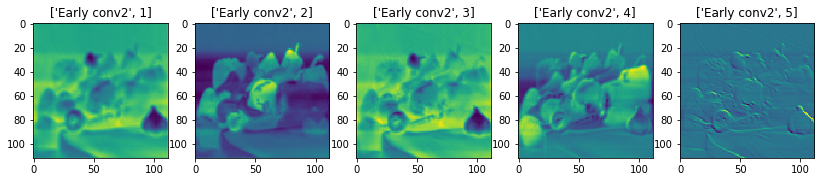

In [17]:
fig = plt.figure(figsize=(14,5))
for i in range(5):
    p = i + 1
    axes = fig.add_subplot(1,5,p)
    plt.imshow(norm(f_early_res_152[0][i].detach().numpy()))
    axes.title.set_text(["Early conv2", p])

### Five interesting feature maps from middle of the network

In [18]:
# Grab some feature maps from middle
f_middle_res_152_model = nn.Sequential(*list(res_152_model.children())[:5])
f_middle_res_152 = f_middle_res_152_model(pep_batch)
f_middle_res_152.shape

torch.Size([1, 256, 56, 56])

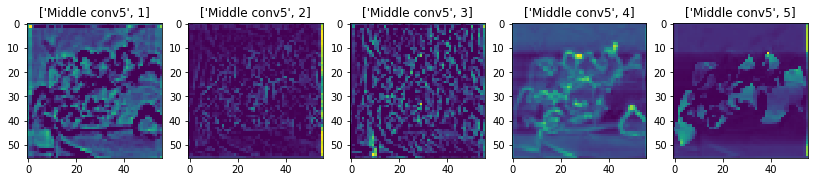

In [19]:
fig = plt.figure(figsize=(14,5))
for i in range(5):
    p = i + 1
    axes = fig.add_subplot(1,5,p)
    plt.imshow(norm(f_middle_res_152[0][i].detach().numpy()))
    axes.title.set_text(["Middle conv5", p])

### Five interesting feature maps from end of the network

In [20]:
# Grab some feature maps from the end
f_end_res_152_model = nn.Sequential(*list(res_152_model.children())[:-2])
f_end_res_152 = f_end_res_152_model(pep_batch)
f_end_res_152.shape

torch.Size([1, 2048, 7, 7])

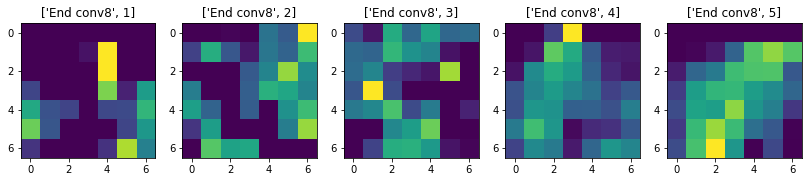

In [21]:
fig = plt.figure(figsize=(14,5))
for i in range(5):
    p = i + 1
    axes = fig.add_subplot(1,5,p)
    plt.imshow(norm(f_end_res_152[0][i].detach().numpy()))
    axes.title.set_text(["End conv8", p])

# Problem 2 - Transfer Learning with a Pre-Trained CNN

In [22]:
# Load labels
pet_df = pd.read_csv("annotations/list.txt", skiprows = 6, sep = " ", header = None)
pet_df.columns = ["Image", "CLASS-ID", "SPECIES", "BREED ID"]
pet_df.index = pet_df["Image"]
pet_df.head(3)

,Image,CLASS-ID,SPECIES,BREED ID
Image,,,,
Abyssinian_100,Abyssinian_100,1,1,1
Abyssinian_101,Abyssinian_101,1,1,1
Abyssinian_102,Abyssinian_102,1,1,1


### Copy images images into train and test folders with corresponding labels folders to use

In [23]:
### ONLY RUN BELOW IF RUNNING FOR THE FIRST TIME TO SPLIT DATA INTO FOLDERS

In [ ]:
# Load the train and test files and store which folder each pic belongs in
pet_train_list = pd.read_table("annotations/trainval.txt", header = None, sep = " ").iloc[:,0].values
pet_test_list = pd.read_table("annotations/test.txt", header = None, sep = " ").iloc[:,0].values

In [ ]:
# Create sub folders
for class_id in pet_df["CLASS-ID"].unique():
    try:
        os.mkdir("images_data/train/" + str(class_id))
        os.mkdir("images_data/test/" + str(class_id))
    except OSError:
        print("Creation of the directory failed" + " images_data/train/" + str(class_id))

In [ ]:
# Load the train and test files and store which folder each pic belongs in
pet_images_name = []
pet_folder_list = []
for filename in os.listdir("images/"):
    if filename[:-4] in pet_train_list:
        pet_images_name.append("images/" + filename)
        pet_folder_list.append("images_data/train/" + str(pet_df.loc[filename[:-4]]["CLASS-ID"]) + "/" + filename)
    elif filename[:-4] in pet_test_list:
        pet_images_name.append("images/" + filename)
        pet_folder_list.append("images_data/test/" + str(pet_df.loc[filename[:-4]]["CLASS-ID"]) + "/" + filename)
    
# Get data set size to split data
pet_dataset_size = len(pet_images_name)
print(pet_dataset_size)

In [ ]:
# Copy file over
for i in range(pet_dataset_size):
    shutil.copyfile(pet_images_name[i], pet_folder_list[i])

In [24]:
##################

In [25]:
# Transform the training and testing data, where training data will have random crop and flip with l2 norm
l2_pet_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [26]:
# Use transform and imagefolder to load all the images into tensors
l2_pet_image_datasets = {x: datasets.ImageFolder(os.path.join("images_data", x),
                                          l2_pet_transforms[x]) for x in ['train', 'test']}
l2_pet_dataloaders = {x: torch.utils.data.DataLoader(l2_pet_image_datasets[x], batch_size = 12,
                                             shuffle = True, num_workers = 0) for x in ['train', 'test']}
# Find the size of the train and test set
dataset_sizes = {x: len(l2_pet_image_datasets[x]) for x in ['train', 'test']}
# Store the labels
class_names = l2_pet_image_datasets['train'].classes

In [27]:
# Check if data loaded
dataset_sizes

{'train': 3680, 'test': 3669}

### Using resnet101 linear classifier

In [28]:
# Load pretrained model
pet_l2_101_model = models.resnet101(pretrained = True)

In [29]:
# Change last layer to our output
num_ftrs_pet = pet_l2_101_model.fc.in_features
pet_l2_101_model.fc = nn.Linear(num_ftrs_pet, len(class_names))

In [30]:
# Use GPU
_ = pet_l2_101_model.to(gpu_device)

In [31]:
# Train function taken from my own train function from project 1 and made adjustments with pytorch
# I read and understand all lines and made a few adjustments to fit my code better
def train_model(model, dataloaders, optimizer, criterion, num_epochs):    
    # Run all the epochs
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        
        print("Epoch", str(epoch + 1), "/", str(num_epochs))
        for stage in ['train', 'test']:
            if stage == 'train':
                model.train()
            else:
                model.eval()
                
            correct_count = 0
            run_loss = 0.0

            # Load data from dataloader
            for data, labels in dataloaders[stage]:
                data = data.to(gpu_device)
                labels = labels.to(gpu_device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(stage == 'train'):
                    outputs = model(data)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Change weights in train stage
                    if stage == 'train':
                        loss.backward()
                        optimizer.step()

                # Add to loss and accuracy
                correct_count += torch.sum(preds == labels.data)
                run_loss += loss.item() * data.size(0)

            epoch_acc = correct_count.double() / dataset_sizes[stage]
            epoch_loss = run_loss / dataset_sizes[stage]
            
            print(stage, "Accuracy ---", epoch_acc.item(), "Loss --- ", epoch_loss)
            
    return model

In [32]:
# Set the criterion
cross_entro = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
sgd = optim.SGD(pet_l2_101_model.parameters(), lr = 0.005, momentum = 0.5)

# Run training
pet_l2_101_model = train_model(pet_l2_101_model, l2_pet_dataloaders, sgd, cross_entro, num_epochs = 3)

Epoch 1 / 3
train Accuracy --- 0.6149456521739131 Loss ---  1.5941675369182358
test Accuracy --- 0.8776233306077951 Loss ---  0.4046622500591169
Epoch 2 / 3
train Accuracy --- 0.8114130434782609 Loss ---  0.6737450355744881
test Accuracy --- 0.9037884982284001 Loss ---  0.31163364869351284
Epoch 3 / 3
train Accuracy --- 0.8361413043478261 Loss ---  0.5456921090574368
test Accuracy --- 0.9040610520577814 Loss ---  0.2916180621863069
